In [33]:
!pip install sunpy[all]

In [1]:
import os
from astropy.io import fits
import sunpy.map
from sunpy.coordinates import NorthOffsetFrame
import astropy.units as u
import numpy as np
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames
import matplotlib.pyplot as plt
import matplotlib.colors
import glob
from scipy import ndimage
import numpy as np
import sunpy.timeseries
import scipy.ndimage as ndimage
from scipy.ndimage import label
from scipy.optimize import curve_fit
from scipy.interpolate import RegularGridInterpolator


In [2]:
folder_path = "/home/anu/Desktop/samapti/carrington"
save_dir1="/home/anu/Desktop/samapti/carrington/South hemisphere"
save_dir2= "/home/anu/Desktop/samapti/carrington/North hemisphere"
files = os.listdir(folder_path)
fits_files = glob.glob(os.path.join(folder_path, '*.fits'))
print(fits_files)

['/home/anu/Desktop/samapti/carrington/synop_Mr_0.1960.fits']


In [3]:
for file in fits_files:
  with fits.open(file)as f:
    header = f[0].header
    data=f[0].data
    #print(header)
    #print(data)

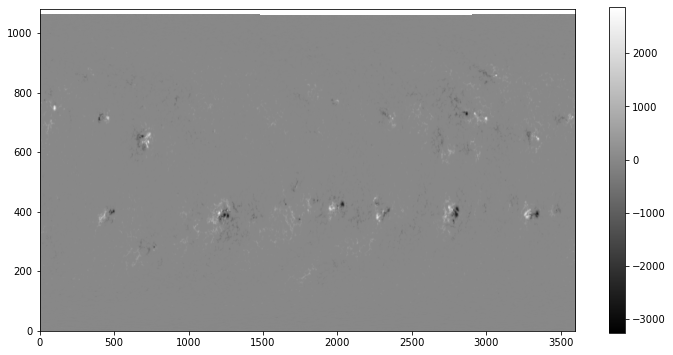

In [4]:
fig = plt.figure(figsize=(12,6))
plt.imshow(data, origin="lower", cmap='gray', aspect=2)
plt.colorbar()

In [46]:
nx=data.shape[1]
ny=data.shape[0]


In [49]:
longitude=[]
longitude_rad=[]
sinlat=[]
latitude=[]
R_sun = 6.96e10
d_sinlat=2/(ny-1)
dtr=np.pi/180
rtd=180/np.pi



for i in range (ny):
  sin_lat= -1+i*(2/(ny-1))
  d_sinlat=2/(ny-1)
  Latitude =np.arcsin(sin_lat)*(180/np.pi)
  Latitude_rad=  (Latitude*np.pi)/180
  latitude.append(Latitude)
  sinlat.append(sin_lat)
for j in range(nx):
    Longitude = 0+j*(360/(nx-1))
    Longitude_rad=Longitude*dtr
    d_lon=360/(nx-1)
    dlon_rad=(d_lon*np.pi)/180
    longitude.append(Longitude)
    #longitude_rad.append(Longitude_rad)
  
Flux=(data)*(R_sun**2)*(d_sinlat)*(dlon_rad)
S= (R_sun**2)*(d_sinlat)*(dlon_rad)
print(S)
#print( longitude_rad[1:6])

1.5675631727393676e+16


In [48]:
print(np.subtract(longitude_rad[2:7], longitude_rad[1:6]))

[0.00174581 0.00174581 0.00174581 0.00174581 0.00174581]


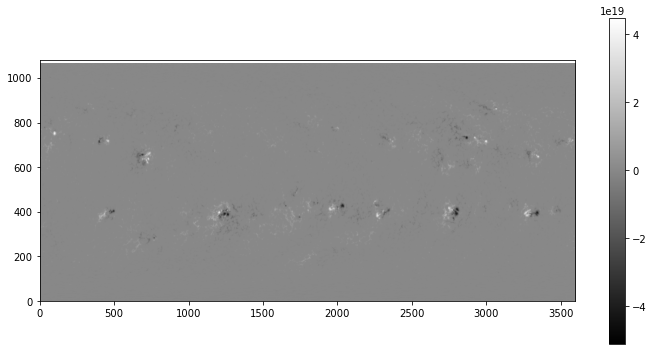

In [50]:
fig = plt.figure(figsize=(12,6))



plt.imshow(Flux,origin="lower", cmap='gray',aspect=1.5)
plt.colorbar()






In [8]:
lon=np.linspace(min(longitude), max(longitude), 1000)
lat= np.linspace(min(latitude), max(latitude),1000)
x,y=np.meshgrid(lon, lat)
flux= RegularGridInterpolator((latitude,longitude),Flux)((y,x))
sinlat=np.linspace(min(sinlat), max(sinlat),1000)
X,Y=np.meshgrid(lon, sinlat )


In [42]:
#print(lon)

/tmp/ipykernel_30669/4007883621.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x,y,flux, cmap='gray')
/tmp/ipykernel_30669/4007883621.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X,Y,flux, cmap='gray')


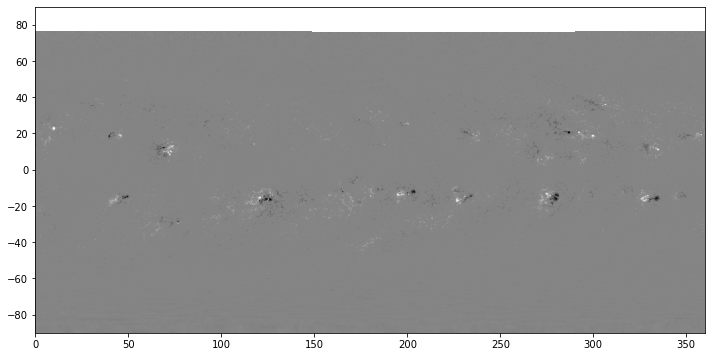

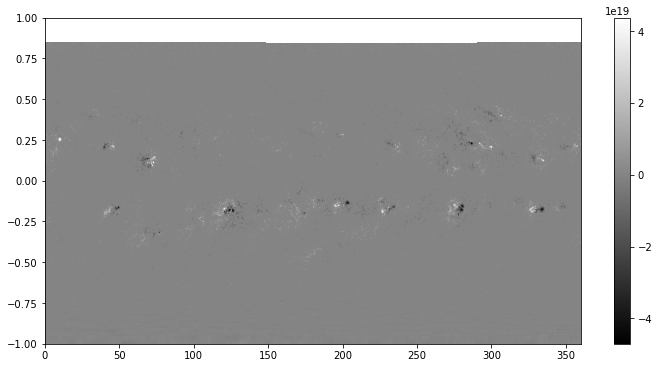

In [9]:
fig=plt.figure(figsize=(12,6))
plt.pcolormesh(x,y,flux, cmap='gray')
fig=plt.figure(figsize=(12,6))
plt.pcolormesh(X,Y,flux, cmap='gray')
plt.colorbar()

In [10]:
fluxthres=0.5e19
binary_mask=np.abs(flux)>fluxthres
labeled_array, num_features = label(binary_mask)
sizes = ndimage.sum(binary_mask, labeled_array, range(1, num_features + 1))
areathres=50
mask_filtered = np.zeros_like(binary_mask)




In [11]:
for i, size in enumerate(sizes):
  if size >=areathres:
    mask_filtered[labeled_array == (i + 1)] = 1


/tmp/ipykernel_30669/2603100432.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x,y, binary_mask, cmap='gray')


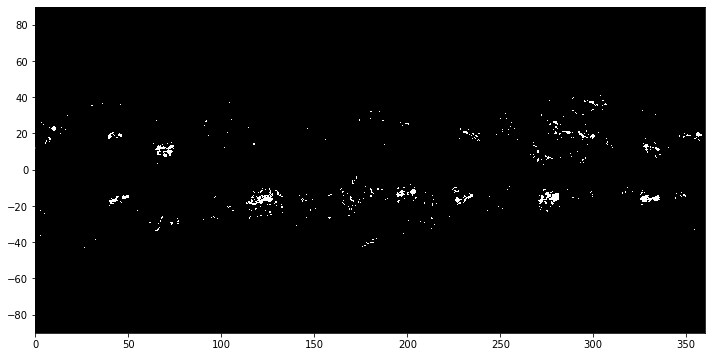

In [12]:
fig=plt.figure(figsize=(12,6))
plt.pcolormesh(x,y, binary_mask, cmap='gray')

In [19]:
y_indices, x_indices = np.where(binary_mask==1)

Lat=lat[y_indices]
Lon=lon[x_indices]
mask1=(Lat<=0)& (Lat>=-90)
SH_lat=Lat[mask1]
SH_lon=Lon[mask1]
mask2= (Lat<=90) & (Lat>=0)
NH_lat = Lat[mask2]
NH_lon = Lon[mask2]

sorted_indices1= np.argsort(SH_lon)
SHlon_sorted=SH_lon[sorted_indices1]
SHlat_sorted=SH_lat[sorted_indices1]
output1=np.column_stack((SHlon_sorted,SHlat_sorted))
#print(output1)
sorted_indices2 = np.argsort(NH_lon)
NHlon_sorted= NH_lon[sorted_indices2]
NHlat_sorted = NH_lat[sorted_indices2]
output2 = np.column_stack((NHlon_sorted, NHlat_sorted))
#print(output2)

In [20]:
base_name = os.path.basename(file).replace('.fits', '')
txt_name1= f" {base_name}_SH.txt"
txt1= os.path.join(save_dir1, txt_name1)
txt_name2= f" {base_name}_NH.txt"
txt2= os.path.join(save_dir2, txt_name2)
np.savetxt(txt1,output1)
np.savetxt(txt2, output2)

In [21]:
folder_path3="/home/anu/Desktop/samapti/carrington/North hemisphere"
NFiles = os.listdir(folder_path3)
txt_files = glob.glob(os.path.join(folder_path3, '*.txt'))
A=[]
B=[]

for NFile in txt_files:
	print(NFile)

/home/anu/Desktop/samapti/carrington/North hemisphere/ synop_Mr_0.1960_NH.txt


In [22]:
with open (NFile, "r") as infile:
  for line in infile:
    parts=line.split()
    if len(parts)==2:
      Nfhi=float(parts[0])
      Nlamda=float(parts[1])
    
      A.append(Nfhi)
      B.append(Nlamda)
     

In [23]:
N=np.array(A)

In [24]:
def model(lon,a,b,c):
  S = (lon*np.pi)/180
  return a+b*np.sin(S+c)                          
params, cov = curve_fit(model,N,B,method = 'trf')                                               #method = 'trf'
print(f"a = {params[0]}, b = {params[1]}, c= {params[2]}")
perr = np.sqrt(np.diag(cov))
print(perr)
print(params)

a = 17.241501402018194, b = 3.291566641419266, c= 2.9519188285418774
[0.21147791 0.22680993 0.10139631]
[17.2415014   3.29156664  2.95191883]


In [21]:
np.linalg.cond(cov)

1.9780599576900582

In [25]:
error1=np.add(perr,params)
error2=np.subtract(params,perr )
print(error2)
print(error1)

[17.03002349  3.06475671  2.85052252]
[17.45297931  3.51837657  3.05331514]


In [27]:
error=[17.03002349, 3.291566641419266, 2.9519188285418774]

/tmp/ipykernel_30669/529936986.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x,y, flux, cmap='gray')


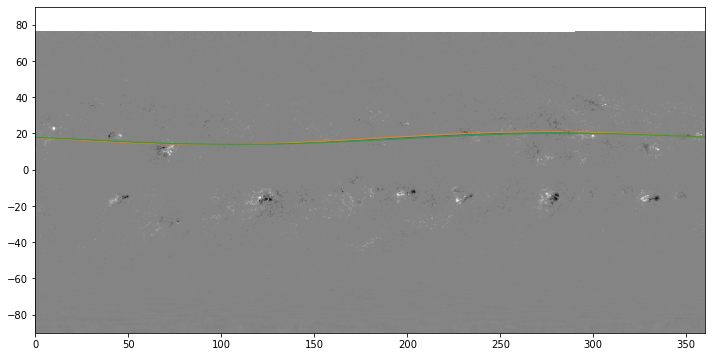

In [30]:
fig = plt.figure(figsize=(12,6))
plt.plot (lon,model(lon, *params), linewidth=1)
plt.plot (lon,model(lon, *error1), linewidth=1)
plt.plot (lon,model(lon, *error2), linewidth=1)

plt.pcolormesh(x,y, flux, cmap='gray')








In [31]:
folder_path3="/home/anu/Desktop/samapti/carrington/South hemisphere"
SFiles = os.listdir(folder_path3)
txt_files = glob.glob(os.path.join(folder_path3, '*.txt'))
P=[]
Q=[]

for Sfile in txt_files:
	print(Sfile)

/home/anu/Desktop/samapti/carrington/South hemisphere/ synop_Mr_0.1960_SH.txt


In [32]:
with open (Sfile, "r") as infile:
  for line in infile:
    parts=line.split()
    if len(parts)==2:
      Sfhi=float(parts[0])
      Slamda=float(parts[1])
      
      P.append(Sfhi)
      Q.append(Slamda)

In [33]:
M=np.array(P)

In [37]:
def model(lon,p,q,r):
  S= (lon*np.pi)/180
  return p+q*np.sin(S+r)
Params, Cov = curve_fit(model,M,Q,method = 'trf')
print(f"p = {Params[0]}, q = {Params[1]}, r={Params[2]}")
Perr = np.sqrt(np.diag(Cov))
print(Cov)
print(Perr)
print(Params)

p = -16.920940771036847, q = 1.9249022844934247, r=3.4682889381284348
[[ 0.00671188 -0.00192111 -0.00139759]
 [-0.00192111  0.01331968  0.00148406]
 [-0.00139759  0.00148406  0.00353841]]
[0.08192608 0.11541093 0.05948452]
[-16.92094077   1.92490228   3.46828894]


In [261]:
np.linalg.cond(Cov)

4.786340022160444

In [38]:
Error1=np.add(Params, Perr)
Error2=np.subtract(Params,Perr )
print(Error2)
print(Error1)

[-17.00286685   1.80949136   3.40880442]
[-16.83901469   2.04031321   3.52777346]


In [39]:
Error=[-17.29212064, 1.9249022844934247, 3.4682889381284348]

/tmp/ipykernel_30669/2021146166.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x,y, flux, cmap='gray')


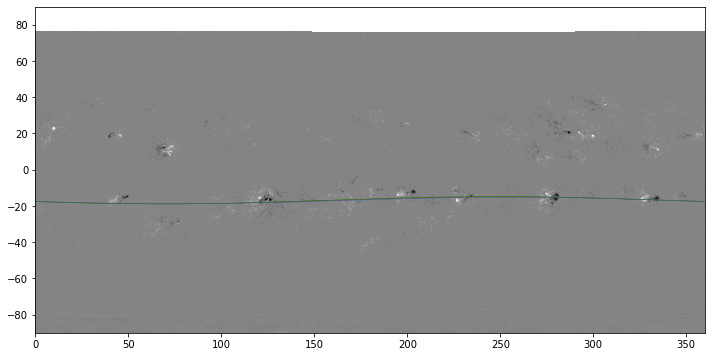

In [42]:
fig = plt.figure(figsize=(12,6))
plt.plot (lon,model(lon, *Params), color="Red" ,linewidth=0.5)
plt.plot (lon,model(lon, *Error1) ,color="g",linewidth=0.5)
plt.plot (lon,model(lon, *Error2) ,linewidth=0.5)

plt.pcolormesh(x,y, flux, cmap='gray')

/tmp/ipykernel_30669/2228533502.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x,y, binary_mask, cmap='gray')


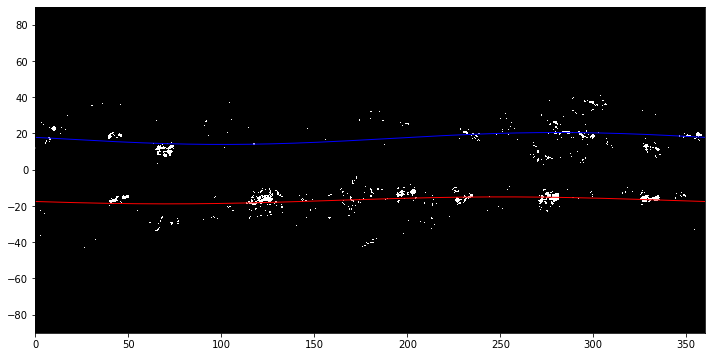

In [44]:
fig = plt.figure(figsize=(12,6))
plt.plot (lon,model(lon, *Params), color="Red" ,linewidth=1)
#plt.plot (lon,model(lon, *Error1) ,color="g",linewidth=0.5)
#plt.plot (lon,model(lon, *Error2) ,linewidth=0.5)

plt.plot (lon,model(lon, *params), color="blue", linewidth=1)
#plt.plot (lon,model(lon, *error1), color="g", linewidth=0.5)
#plt.plot (lon,model(lon, *error2), linewidth=0.5)

plt.pcolormesh(x,y, binary_mask, cmap='gray')